In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.neighbors import KernelDensity

import torch
from torch.optim.lr_scheduler import StepLR

from models import *
from training import CallBacks, Stream, Trainer
from utils import get_input_size, count_parameters
from viz import plot_training_results

path = "/Users/raphaelbordas/Code/sandbox_deep_learning/"

In [19]:
input_size = 3  # 3 channels for CIFAR10
classes = 10
# modules = [2, 2, 2]
modules = [6, 6, 6]
features = [16, 32, 64]
plain14 = PlainNet(input_size, classes, module_list=modules, features_shapes=features)
resnet14 = ResNet(input_size, classes, module_list=modules, features_shapes=features)
xavier_weights(plain14)
xavier_weights(resnet14)
resnet14.to(device=torch.device("mps"))
plain14.to(device=torch.device("mps"))

optimizer_plain = torch.optim.SGD(plain14.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
optimizer_resnet = torch.optim.SGD(resnet14.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)

plain, _, checkpoint_plain = Trainer(plain14, optimizer_plain, criterion=nn.CrossEntropyLoss(),
                                     device=torch.device("mps")).load_state(
    f"{path}/projet_dl/derivatives/grad_analysis/PlainNet_38_with_grad_SGD_CIFAR10_epo_5.pt"
)
resnet, _, checkpoint_resnet = Trainer(resnet14, optimizer_resnet, criterion=nn.CrossEntropyLoss(),
                                       device=torch.device("mps")).load_state(
    f"{path}/projet_dl/derivatives/grad_analysis/ResNet_38_with_grad_SGD_CIFAR10_epo_5.pt"
)

In [8]:
list(plain.modules())[1:]

[Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ModuleList(
   (0): Sequential(
     (0): ConvPlainBlock(
       (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
     (1): ConvPlainBlock(
       (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): Sequential(
     (0): ConvPlainBloc

In [7]:
list(resnet.modules())[1:]

[Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ModuleList(
   (0): Sequential(
     (0): ConvResBlock(
       (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
     (1): ConvResBlock(
       (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): Sequential(
     (0): ConvResBlock(
   

In [41]:
print([k for k in checkpoint_plain["grads"].keys() if "conv" in k and "bias" not in k and "skip" not in k].__len__())
print([k for k in checkpoint_resnet["grads"].keys() if "conv" in k and "bias" not in k and "skip" not in k].__len__())
[k for k in checkpoint_resnet["grads"].keys() if "conv" in k and "bias" not in k and "skip" not in k].index("res_blocks.2.1.conv2.weight")

37
37


28

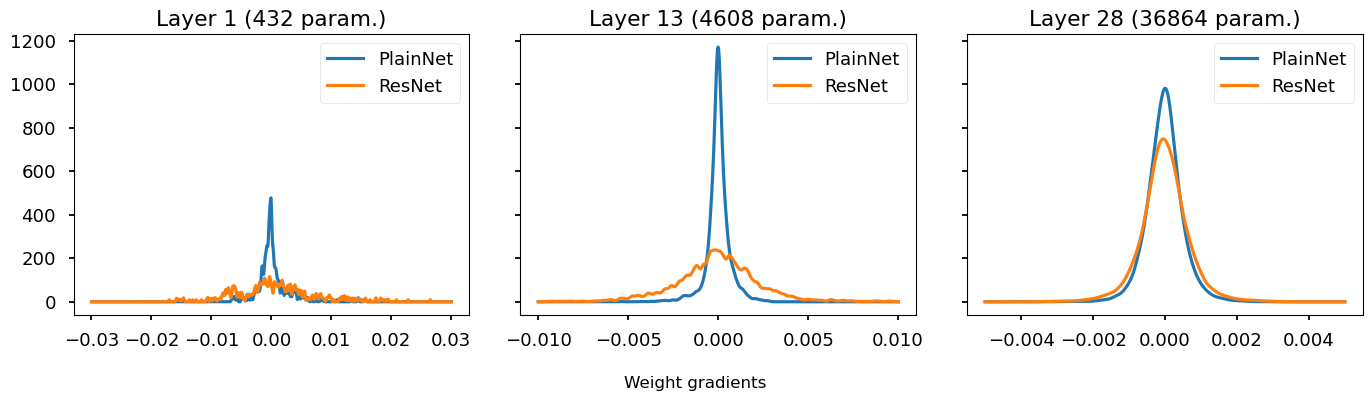

In [54]:
grad_plain_l1 = checkpoint_plain["grads"]["conv1.weight"]
grad_plain_lmid = checkpoint_plain["grads"]["res_blocks.1.0.conv1.weight"]
grad_plain_l13 = checkpoint_plain["grads"]["res_blocks.2.1.conv2.weight"]
grad_resnet_l1 = checkpoint_resnet["grads"]["conv1.weight"]
grad_resnet_lmid = checkpoint_resnet["grads"]["res_blocks.1.0.conv1.weight"]
grad_resnet_l13 = checkpoint_resnet["grads"]["res_blocks.2.1.conv2.weight"]


def get_kde_estimate(x, xnew, bandwidth=0.0001):
    kde_ = KernelDensity(kernel="gaussian", bandwidth=bandwidth).fit(x.reshape(-1, 1))
    log_dens_ = kde_.score_samples(xnew)
    return np.exp(log_dens_)

plt.style.use("seaborn-v0_8-talk")
fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharex=False, sharey=True)
x = np.linspace(-0.03, 0.03, 1000)[:, np.newaxis]
# axes[0].hist(grad_plain_l1.cpu().detach().flatten(), bins=50, density=True, label="PlainNet")
axes[0].plot(x, get_kde_estimate(grad_plain_l1.cpu().detach().flatten(), x), label="PlainNet")
axes[0].plot(x, get_kde_estimate(grad_resnet_l1.cpu().detach().flatten(), x), label="ResNet")
# axes[0].hist(grad_resnet_l1.cpu().detach().flatten(), bins=50, density=True, alpha=0.3, label="ResNet")
x = np.linspace(-0.01, 0.01, 1000)[:, np.newaxis]
# axes[1].hist(grad_plain_lmid.cpu().detach().flatten(), bins=100, density=True, label="PlainNet")
# axes[1].hist(grad_resnet_lmid.cpu().detach().flatten(), bins=100, density=True, alpha=0.3, label="ResNet")
axes[1].plot(x, get_kde_estimate(grad_plain_lmid.cpu().detach().flatten(), x), label="PlainNet")
axes[1].plot(x, get_kde_estimate(grad_resnet_lmid.cpu().detach().flatten(), x), label="ResNet")
x = np.linspace(-0.005, 0.005, 1000)[:, np.newaxis]
# axes[2].hist(grad_plain_l13.cpu().detach().flatten(), bins=100, density=True, label="PlainNet")
axes[2].plot(x, get_kde_estimate(grad_plain_l13.cpu().detach().flatten(), x), label="PlainNet")
axes[2].plot(x, get_kde_estimate(grad_resnet_l13.cpu().detach().flatten(), x), label="ResNet")
# axes[2].hist(grad_resnet_l13.cpu().detach().flatten(), bins=100, density=True, alpha=0.3, label="ResNet")
axes[0].set_title(f"Layer 1 ({len(grad_plain_l1.cpu().detach().flatten())} param.)")
axes[1].set_title(f"Layer 13 ({len(grad_plain_lmid.cpu().detach().flatten())} param.)")
axes[2].set_title(f"Layer 28 ({len(grad_plain_l13.cpu().detach().flatten())} param.)")
axes[0].legend()
axes[1].legend()
axes[2].legend()
fig.supxlabel("Weight gradients")
fig.tight_layout()
plt.show()
fig.savefig("../results/ResNet_vs_PlainNet_38_weight_gradients_distribution.pdf")

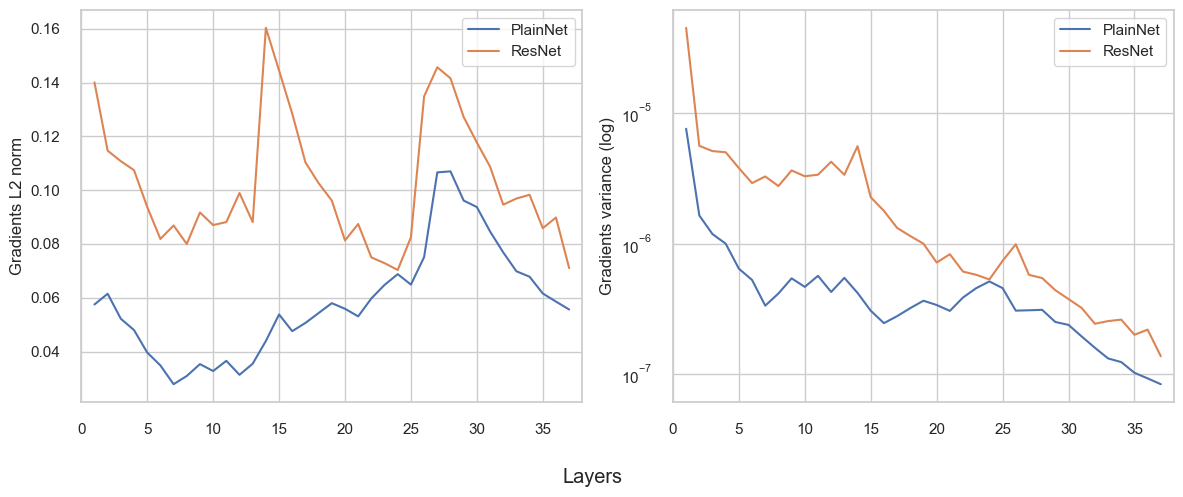

In [79]:
# layers of interest
layers = [k for k in checkpoint_resnet["grads"].keys() if "conv" in k and "bias" not in k and "skip" not in k]

grads = pd.DataFrame({
    "layer": layers,
    "plain_norm": [np.linalg.norm(checkpoint_plain["grads"][k].cpu().detach().flatten()) for k in layers],
    "resnet_norm": [np.linalg.norm(checkpoint_resnet["grads"][k].cpu().detach().flatten()) for k in layers],
    "plain_var": [np.var(checkpoint_plain["grads"][k].cpu().detach().flatten().numpy()) for k in layers],
    "resnet_var": [np.var(checkpoint_resnet["grads"][k].cpu().detach().flatten().numpy()) for k in layers]
})

plt.style.use("seaborn-v0_8-talk")
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=False, sharey=False)
layers_idx = np.arange(len(layers)) + 1
axes[0].plot(layers_idx, grads["plain_norm"], label="PlainNet")
axes[0].plot(layers_idx, grads["resnet_norm"], label="ResNet")
axes[1].plot(layers_idx, grads["plain_var"], label="PlainNet")
axes[1].plot(layers_idx, grads["resnet_var"], label="ResNet")
axes[1].set_yscale("log")
axes[0].legend()
axes[1].legend()
axes[0].set_ylabel("Gradients L2 norm")
axes[1].set_ylabel("Gradients variance (log)")
axes[0].set_xlim(0, len(layers) + 1)
axes[1].set_xlim(0, len(layers) + 1)
fig.supxlabel("Layers")
fig.tight_layout()
plt.show()
fig.savefig("../results/ResNet_vs_PlainNet_38_weight_gradients_norm_var.pdf")

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37])

AttributeError: 'NoneType' object has no attribute 'cpu'

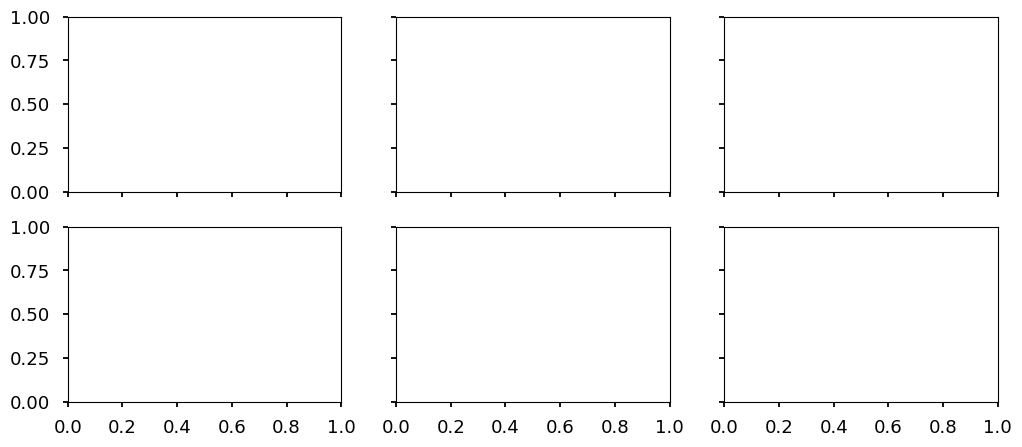

In [7]:
plt.style.use("seaborn-v0_8-talk")
# plot the histogram of the weights
# plt.hist(trainer.model.conv1.weight.cpu().detach().numpy().flatten(), bins=100)
fig, axes = plt.subplots(2, 3, figsize=(12, 5), sharex=True, sharey=True)
axes = axes.flatten()

x_plot = np.linspace(-1, 1, 1000)[:, np.newaxis]


def get_weight_gradient(layer):
    w = layer.weight.grad.cpu().detach().flatten()
    kde_ = KernelDensity(kernel="gaussian", bandwidth=0.005).fit(w.reshape(-1, 1))
    log_dens_ = kde_.score_samples(x_plot)
    return np.exp(log_dens_)


# first layer of the residual learning
grad_dens = get_weight_gradient(resnet20.res_blocks[0][0].conv1[0])
axes[0].plot(x_plot[:, 0], grad_dens, label="ResNet")
grad_dens = get_weight_gradient(plain20.res_blocks[0][0].conv1[0])
axes[0].plot(x_plot[:, 0], grad_dens, label="PlainNet")

# intermediate layer of the residual learning
grad_dens = get_weight_gradient(resnet20.res_blocks[1][0].conv1[0])
axes[1].plot(x_plot[:, 0], grad_dens, label="ResNet")
grad_dens = get_weight_gradient(plain20.res_blocks[1][0].conv1[0])
axes[1].plot(x_plot[:, 0], grad_dens, label="PlainNet")

grad_dens = get_weight_gradient(resnet20.res_blocks[2][-1].conv1[0])
axes[2].plot(x_plot[:, 0], grad_dens, label="ResNet")
grad_dens = get_weight_gradient(plain20.res_blocks[2][-1].conv1[0])
axes[2].plot(x_plot[:, 0], grad_dens, label="PlainNet")

axes[0].set_xlim(-1, 1)
# axes[1].set_ylim(-0.1, 6.1)
axes[0].set_xticks([-0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75])
axes[0].legend()
axes[1].legend()
axes[2].legend()
fig.supxlabel("Weight gradients")
fig.tight_layout()
plt.show()
fig.savefig("../results/ResNet_vs_PlainNet_weight_gradients.pdf")

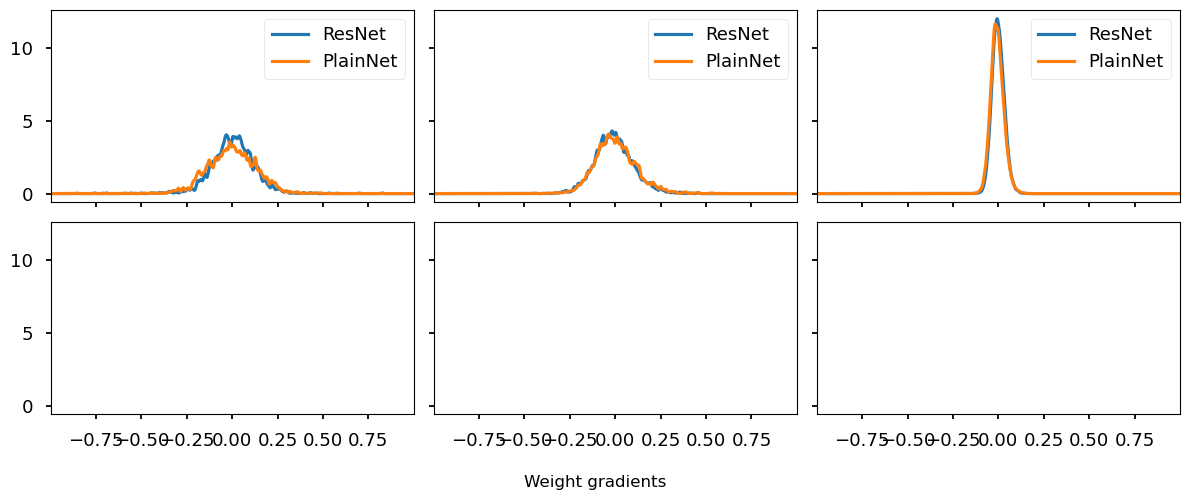

In [153]:
from sklearn.neighbors import KernelDensity

plt.style.use("seaborn-v0_8-talk")
# plot the histogram of the weights
# plt.hist(trainer.model.conv1.weight.cpu().detach().numpy().flatten(), bins=100)
fig, axes = plt.subplots(2, 3, figsize=(12, 5), sharex=True, sharey=True)
axes = axes.flatten()

x_plot = np.linspace(-1, 1, 1000)[:, np.newaxis]


def get_weight(layer):
    w = layer.weight.cpu().detach().flatten()
    kde_ = KernelDensity(kernel="gaussian", bandwidth=0.005).fit(w.reshape(-1, 1))
    log_dens_ = kde_.score_samples(x_plot)
    return np.exp(log_dens_)


# first layer of the residual learning
grad_dens = get_weight(resnet20.res_blocks[0][0].conv1[0])
axes[0].plot(x_plot[:, 0], grad_dens, label="ResNet")
grad_dens = get_weight(plain20.res_blocks[0][0].conv1[0])
axes[0].plot(x_plot[:, 0], grad_dens, label="PlainNet")

# intermediate layer of the residual learning
grad_dens = get_weight(resnet20.res_blocks[1][0].conv1[0])
axes[1].plot(x_plot[:, 0], grad_dens, label="ResNet")
grad_dens = get_weight(plain20.res_blocks[1][0].conv1[0])
axes[1].plot(x_plot[:, 0], grad_dens, label="PlainNet")

grad_dens = get_weight(resnet20.res_blocks[2][-1].conv1[0])
axes[2].plot(x_plot[:, 0], grad_dens, label="ResNet")
grad_dens = get_weight(plain20.res_blocks[2][-1].conv1[0])
axes[2].plot(x_plot[:, 0], grad_dens, label="PlainNet")

axes[0].set_xlim(-1, 1)
# axes[1].set_ylim(-0.1, 6.1)
axes[0].set_xticks([-0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75])
axes[0].legend()
axes[1].legend()
axes[2].legend()
fig.supxlabel("Weight gradients")
fig.tight_layout()
plt.show()
fig.savefig("../results/ResNet_vs_PlainNet_weight_gradients.pdf")

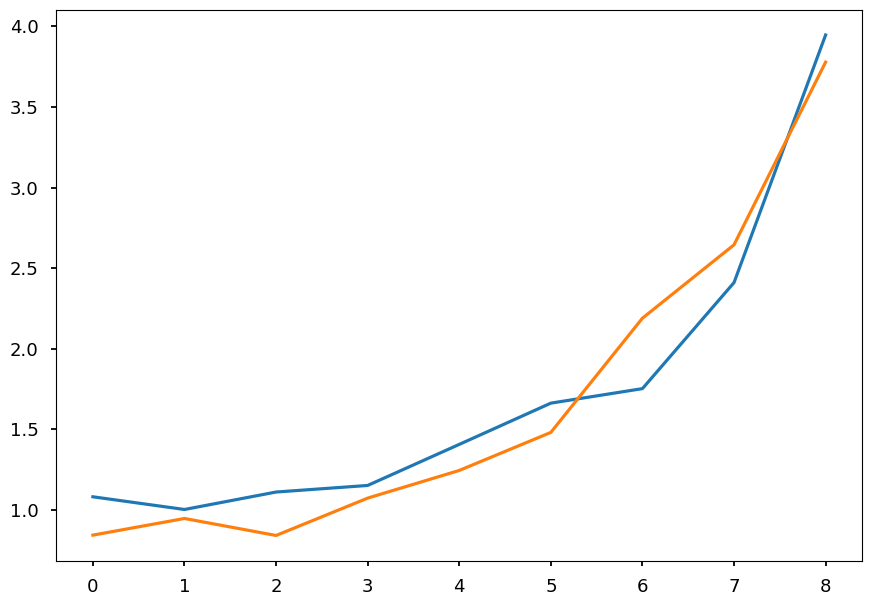

In [160]:
layers = [(i, j) for i in range(3) for j in range(3)]

grads_resnet = [np.var(get_weight(resnet20.res_blocks[i][j].conv1[0])) for i, j in layers]
grads_plain = [np.var(get_weight(plain20.res_blocks[i][j].conv1[0])) for i, j in layers]

plt.plot(grads_resnet, label="ResNet")
plt.plot(grads_plain, label="PlainNet")

In [169]:
input_size = get_input_size(train_loader)
modules = [6, 6, 6]
features_shapes = [16, 32, 64]
plain38 = PlainNet(input_size[1], len(classes), module_list=modules, features_shapes=features_shapes)
resnet38 = ResNet(input_size[1], len(classes), module_list=modules, features_shapes=features_shapes,
                  block_type=ConvResBlock)
optimizer = torch.optim.SGD(plain38.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
optimizer2 = torch.optim.SGD(resnet38.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=40, gamma=0.1)
scheduler2 = StepLR(optimizer2, step_size=40, gamma=0.1)
criterion = nn.CrossEntropyLoss()

resnet38.to(device=torch.device("mps"))
plain38.to(device=torch.device("mps"))
torch.set_grad_enabled(True)
trainer = Trainer(resnet38, optimizer2, scheduler, criterion, callbacks=CallBacks(Stream()),
                  device=torch.device("mps"), save_path=path)
resnet38, _, _ = trainer.load_state(
    "/Users/raphaelbordas/Code/sandbox_deep_learning/projet_dl/derivatives/ResNet_38_SGD_CIFAR10_epo_20.pth")

trainer = Trainer(plain38, optimizer, scheduler, criterion, callbacks=CallBacks(Stream()),
                  device=torch.device("mps"), save_path=path)
plain38, _, _ = trainer.load_state(
    "/Users/raphaelbordas/Code/sandbox_deep_learning/projet_dl/derivatives/PlainNet_38_SGD_CIFAR10_epo_20.pth")

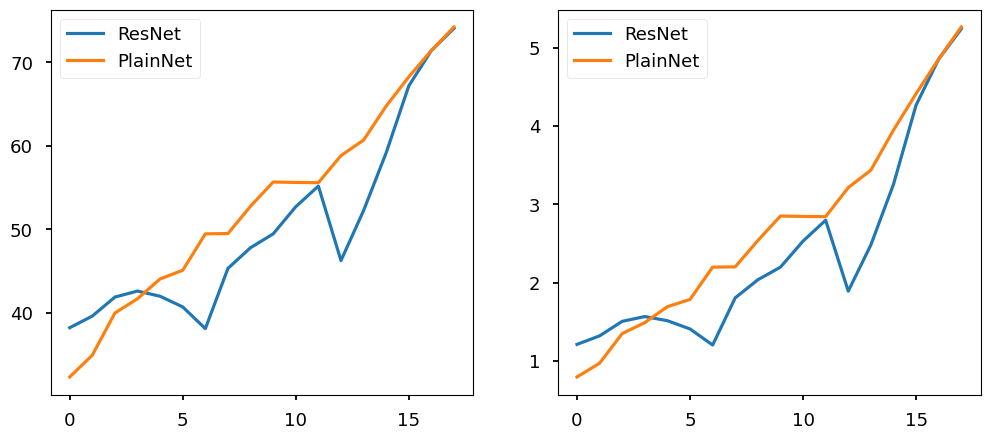

In [173]:
layers = [(i, j) for i in range(3) for j in range(6)]

grads_resnet = [np.linalg.norm(get_weight(resnet38.res_blocks[i][j].conv1[0])) for i, j in layers]
grads_plain = [np.linalg.norm(get_weight(plain38.res_blocks[i][j].conv1[0])) for i, j in layers]

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=False)

axes[0].plot(grads_resnet, label="ResNet")
axes[0].plot(grads_plain, label="PlainNet")

grads_resnet = [np.var(get_weight(resnet38.res_blocks[i][j].conv1[0])) for i, j in layers]
grads_plain = [np.var(get_weight(plain38.res_blocks[i][j].conv1[0])) for i, j in layers]

axes[1].plot(grads_resnet, label="ResNet")
axes[1].plot(grads_plain, label="PlainNet")

axes[0].legend()
axes[1].legend()

In [184]:
i = 0
for p in resnet38.parameters():
    print('===========\ngradient:\n----------\n{}'.format(p))
    i += 1
    if i > 10:
        break

gradient:
----------
Parameter containing:
tensor([[[[-0.0808,  0.1843,  0.1061],
          [ 0.1352, -0.5940,  0.1913],
          [ 0.1827,  0.1881,  0.1764]],

         [[-0.2864,  0.0114,  0.2908],
          [-0.1565, -0.9584,  0.1143],
          [ 0.1089,  0.0769,  0.2655]],

         [[-0.1996, -0.1195,  0.0485],
          [-0.1985, -0.7245,  0.0370],
          [-0.0065, -0.0501,  0.2849]]],


        [[[ 0.1620,  0.4736,  0.3155],
          [-0.0078,  0.2680,  0.2798],
          [-0.0503, -0.2204, -0.0722]],

         [[-0.0825,  0.4531,  0.1677],
          [-0.3601,  0.1353, -0.1088],
          [-0.4264, -0.7132, -0.6756]],

         [[ 0.2705,  0.6371,  0.3898],
          [ 0.1462,  0.4683,  0.1957],
          [-0.0481, -0.0412, -0.2111]]],


        [[[-0.1357, -0.0540, -0.2695],
          [ 0.1863,  0.2413, -0.0463],
          [ 0.0033,  0.1191,  0.1320]],

         [[ 0.0025, -0.1029, -0.2446],
          [ 0.1248,  0.3002, -0.1243],
          [-0.0131,  0.1155,  0.0618]],

 

tensor(3.3323) torch.Size([36864])
tensor(4.0355) torch.Size([36864])


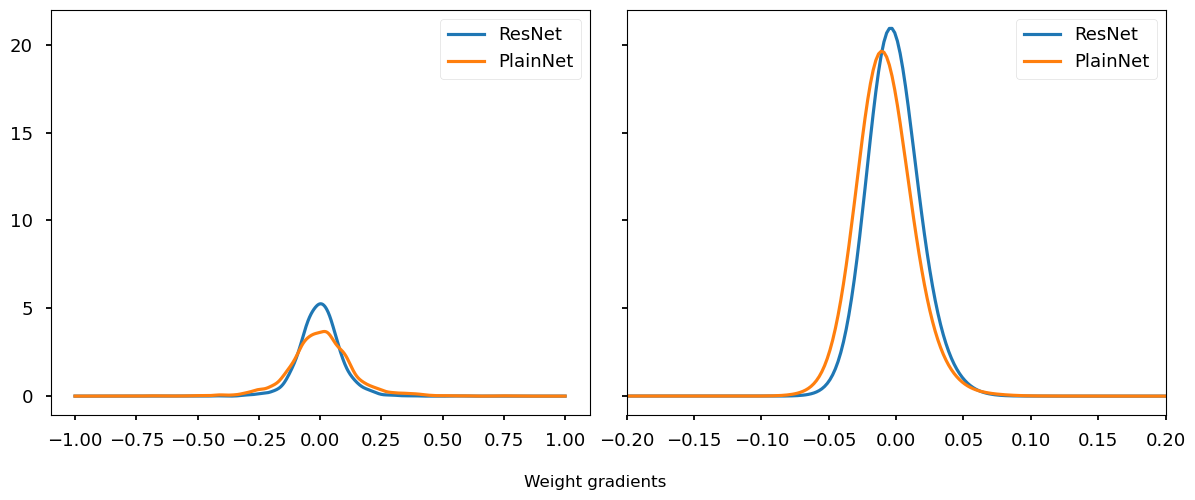

In [145]:
import numpy as np
from sklearn.neighbors import KernelDensity

plt.style.use("seaborn-v0_8-talk")
# plot the histogram of the weights
# plt.hist(trainer.model.conv1.weight.cpu().detach().numpy().flatten(), bins=100)
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=False, sharey=True)

x_plot = np.linspace(-1, 1, 1000)[:, np.newaxis]

grad = resnet38.res_blocks[0][0].conv1[0].weight.cpu().detach().flatten()
kde = KernelDensity(kernel="gaussian", bandwidth=0.02).fit(grad.reshape(-1, 1))
log_dens = kde.score_samples(x_plot)
# axes[0].hist(grad, bins=100, label="Block 1", density=True)
axes[0].plot(x_plot[:, 0], np.exp(log_dens), label="ResNet")

grad = plain38.res_blocks[0][0].conv1[0].weight.cpu().detach().flatten()
kde = KernelDensity(kernel="gaussian", bandwidth=0.02).fit(grad.reshape(-1, 1))
log_dens = kde.score_samples(x_plot)
axes[0].plot(x_plot[:, 0], np.exp(log_dens), label="PlainNet")
# axes[0].hist(grad, bins=100, alpha=0.3, density=True, label="PlainNet")

grad = resnet38.res_blocks[2][5].conv1[0].weight.cpu().detach().flatten()
print(grad.norm(), grad.shape)
kde = KernelDensity(kernel="gaussian", bandwidth=0.01).fit(grad.reshape(-1, 1))
log_dens = kde.score_samples(x_plot)
# axes[0].hist(grad, bins=100, label="Block 1", density=True)
axes[1].plot(x_plot[:, 0], np.exp(log_dens), label="ResNet")

grad = plain38.res_blocks[2][5].conv1[0].weight.cpu().detach().flatten()
print(grad.norm(), grad.shape)
kde = KernelDensity(kernel="gaussian", bandwidth=0.01).fit(grad.reshape(-1, 1))
log_dens = kde.score_samples(x_plot)
axes[1].plot(x_plot[:, 0], np.exp(log_dens), label="PlainNet")
# axes[1].hist(grad, bins=100, alpha=0.3, density=True, label="PlainNet")

axes[1].set_xlim(-0.2, 0.2)
# axes[1].set_ylim(-0.1, 10)
# axes[1].set_xticks([-0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75])
axes[0].legend()
axes[1].legend()
fig.supxlabel("Weight gradients")
fig.tight_layout()
plt.show()
fig.savefig("../results/ResNet_vs_PlainNet_weight_gradients.pdf")